# Generate surface density projections with BH positions

In [1]:
import numpy as np
import os
import h5py
import readtreeHDF5
import matplotlib.pyplot as plt
import arepoutil_serial.utils as util
import arepoutil_serial.snapHDF5 as ws
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import illustris_python.snapshot as snapshot
import illustris_python.groupcat as gc
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import utils as fable_util

In [2]:
import matplotlib.font_manager

fpaths = matplotlib.font_manager.findSystemFonts()
plt.rc('font', family='Nimbus Roman', size = 9)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

In [3]:
LITTLE_H = 0.679
DM_MASS = 3.4e7 / LITTLE_H
SOFTENING_LENGTH = 14.3606
STELLAR_MASS = 6.4e6/LITTLE_H
basepath = '/cosma7/data/dp012/dc-bigw2/FABLE-NewICs/FABLE-newICs-100'
path_to_extended_merger_files = '/cosma7/data/dp012/dc-butt3/new_merger_events_extended/'
treedir = '/cosma7/data/dp012/dc-butt3/MergerTrees/output/Galaxies/FABLE/Fid_test' # path to subhalo merger trees

In [4]:
def get_density_projection(snap_no, subhalo_pos_1, subhalo_pos_2, vmax1, vmax2, parttype=0):
    scale_factors = fable_util.get_scale_factors()
    scale_factor = scale_factors[snap_no]
    redshift = 1/scale_factor - 1

    if subhalo_pos_1 is None or subhalo_pos_2 is None:
        print('No subhalo positions found for snap:', snap_no)
        return
    
    print('Plotting snap:', snap_no)
    UnitMass = 1.989e+43
    UnitVel = 1.e5

    snap = os.path.join(basepath, 'snapdir_{:03d}'.format(snap_no), 'snap_{:03d}'.format(snap_no))

    # find the midpoint between the two galaxies
    midpoint = (subhalo_pos_1 + subhalo_pos_2) / 2

    #recenter the box
    com = midpoint

    # find the distance between the midpoint and the galaxy
    # add the largest of the vmax to calculate the box size

    dist = np.linalg.norm(subhalo_pos_1 - midpoint)
    max_vmax = max(vmax1, vmax2)
    box_size = dist + max_vmax

    dim = box_size * 2
    pixels = 1024
    hDim = dim / 2

    posg = ws.read_block(snap,"POS ", parttype)
    massg = ws.read_block(snap,"MASS", parttype)
    rhog = ws.read_block(snap,"RHO ", parttype)
    volg = massg / rhog
    hsml = 2.5 * (volg * 3 / 4 / np.pi)**(1/3)

    shifted_posg = posg - com

    ## find gas within cube with length dim
    incg = util.cutCubeIndices(shifted_posg, -hDim)

    # Calculates the surface density of "quantity"
    # image will be x_pixels by y_pixels in size and span height, width and depth
    # In this case total mass / UnitArea
    projectRho = util.doProjection(shifted_posg[incg], massg[incg], hsml[incg], pixels, pixels, dim, dim, dim*5)

    return projectRho, hDim, midpoint, box_size

In [7]:
def get_information(merger_index, verbose = False):
    
    def load_bh_data(hf, bh_key):
        bh_data = hf[bh_key]
        snap_numbers = np.array(bh_data['SnapNum'])
        return {
            'Group_Number': dict(zip(snap_numbers, np.array(bh_data['Group_Number']))),
            'Group_R_Crit200': dict(zip(snap_numbers, np.array(bh_data['Group_R_Crit200']))),
            'BH_Mass': dict(zip(snap_numbers, np.array(bh_data['BH_Mass']))),
            'Coordinates': dict(zip(snap_numbers, np.array(bh_data['Coordinates']))),
            'SubfindID': dict(zip(snap_numbers, np.array(bh_data['SubfindID']))),
            'SubhaloMassInRad': dict(zip(snap_numbers, np.array(bh_data['SubhaloMassInRad']))),
            'Central_Subhalo': dict(zip(snap_numbers, np.array(bh_data['Central_Subhalo']))),
        }, snap_numbers
    
    filename = f'{merger_index}.hdf5'

    file_path = os.path.join(path_to_extended_merger_files, filename)

    with h5py.File(file_path, 'r') as hf:
        header = dict(hf['Header'].attrs.items())
        id1, id2 = header['id1'], header['id2']
        formation_time = header['formation_scale_factor']

        bh1_data, snap_numbers = load_bh_data(hf, 'bh1')
        bh2_data, _ = load_bh_data(hf, 'bh2')

    merger_snap = snap_numbers[0]

    # What are the common snap numbers where both BHs exist
    common_keys = set(bh1_data['BH_Mass'].keys()).intersection(set(bh2_data['BH_Mass'].keys()))
    # Findin the snaps where both BHs are in central subhalos
    filtered_keys = [key for key in common_keys if bh1_data['Central_Subhalo'][key] == 1 and bh2_data['Central_Subhalo'][key] == 1 and bh1_data['Group_Number'][key] != bh2_data['Group_Number'][key]]

    if filtered_keys:
        initial_snap = max(filtered_keys)
        if verbose:
            print('Largest snap where both BHs were in central subhalos:', initial_snap)
    else:
        initial_snap = min(common_keys) 
        if verbose:
            print('No common snap found so using the earliest snap where both BHs exist: ', initial_snap)

    total_mass_1 = bh1_data['SubhaloMassInRad'][initial_snap]*1e10/LITTLE_H
    total_mass_2 = bh2_data['SubhaloMassInRad'][initial_snap]*1e10/LITTLE_H
    snap_to_add_1 = 1

    # Check snap after if the mass is negative (i.e. the BH is not in a subhalo)
    while total_mass_1 < 0:
        try:
            total_mass_1 = bh1_data['Central_Subhalo'][initial_snap + snap_to_add_1]*1e10/LITTLE_H
        except KeyError:
            total_mass_1 = 0
        snap_to_add_1 += 1
    snap_to_add_2 = 1
    while total_mass_2 < 0:
        try:
            total_mass_2 =  bh2_data['Central_Subhalo'][initial_snap + snap_to_add_2]*1e10/LITTLE_H
        except KeyError:
            total_mass_2 = 0
        snap_to_add_2 += 1
    
    # Only keep processing event if the host subhalos at initial_snap are massive enough.
    if total_mass_1 < 100*STELLAR_MASS and total_mass_2 < 100*STELLAR_MASS:
        return None, None, None, None, None
    
    tree = readtreeHDF5.TreeDB(treedir)

    # Ensuring that both host subhalos have a valid subfindID
    good_snap = False

    while not good_snap:
        if bh1_data['SubfindID'][initial_snap] != -1 and bh2_data['SubfindID'][initial_snap] != -1:
            good_snap = True
        if not good_snap: # move forward in time until both subfindIDs are valid.
            initial_snap += 1

    # Load subhalo data from the merger trees

    subhalo_quants = ['SubhaloGrNr', 'SubhaloPos', 'SnapNum', 'SubfindID', 'SubhaloVmax']

    subfindID1 = bh1_data['SubfindID'][initial_snap]
    subfindID2 = bh2_data['SubfindID'][initial_snap]

    past_branch1 = tree.get_main_branch(initial_snap, subfindID1, keysel=subhalo_quants)
    fut_branch1 = tree.get_future_branch(initial_snap, subfindID1, keysel=subhalo_quants)

    past_branch2 = tree.get_main_branch(initial_snap, subfindID2, keysel=subhalo_quants)
    fut_branch2 = tree.get_future_branch(initial_snap, subfindID2, keysel=subhalo_quants)

    for b,branch in enumerate([past_branch1, fut_branch1]):
        snaps = branch.SnapNum
        host1_pos = branch.SubhaloPos 
        subfind_id1 = branch.SubfindID
        vmax1 = branch.SubhaloVmax
        if b>0:
            pos_dict_future = dict(zip(snaps, host1_pos))
            subfind_dict_future1 = dict(zip(snaps, subfind_id1))
            vmax_dict_future = dict(zip(snaps, vmax1))
            pos_dict_combined1 = {**pos_dict_past, **pos_dict_future}
            subfind_dict_combined1 = {**subfind_dict_past1, **subfind_dict_future1}
            vmax_dict_combined1 = {**vmax_dict_past, **vmax_dict_future}
        else:
            pos_dict_past = dict(zip(snaps, host1_pos))
            subfind_dict_past1 = dict(zip(snaps, subfind_id1))
            vmax_dict_past = dict(zip(snaps, vmax1))

        for b,branch in enumerate([past_branch2, fut_branch2]):
            snaps = branch.SnapNum
            host2_pos = branch.SubhaloPos
            subfind_id2 = branch.SubfindID
            vmax2 = branch.SubhaloVmax
            if b>0:
                pos_dict_future = dict(zip(snaps, host2_pos))
                subfind_dict_future2 = dict(zip(snaps, subfind_id2))
                vmax_dict_future = dict(zip(snaps, vmax2))
                pos_dict_combined2 = {**pos_dict_past, **pos_dict_future}
                subfind_dict_combined2 = {**subfind_dict_past2, **subfind_dict_future2}
                vmax_dict_combined2 = {**vmax_dict_past, **vmax_dict_future}
            else:
                pos_dict_past = dict(zip(snaps, host2_pos))
                subfind_dict_past2 = dict(zip(snaps, subfind_id2))
                vmax_dict_past = dict(zip(snaps, vmax2))

    # check when the two subhalos merge, if at all
    if initial_snap:
        merge_by_now = False
        merger_snap = snap_numbers[0]
        max_snap = min(max(subfind_dict_combined1.keys()), max(subfind_dict_combined2.keys()))
        host_merger_snap = 0
        for snap in range(merger_snap, max_snap):
            # two subhalos are considered merged when their subfindIDs are the same
            if snap in subfind_dict_combined1.keys() and snap in subfind_dict_combined2.keys():
                if subfind_dict_combined1[snap] == subfind_dict_combined2[snap]:
                    host_merger_snap = snap
                    merge_by_now = True
                    break

        if max_snap == 135 and host_merger_snap == 0: # this is the case where the host subhalos do not merge before redshift 0
            if verbose:
                print('The last snap before BH merger:', merger_snap)
                print('The host subhalos did not merge before redshift 0')
            host_merger_snap = max_snap
        elif max_snap !=135 and host_merger_snap == 0:
            # subhalos haven't merged before one of them ceases to exist.
            # in this case I will set the host_merger_snap to the last snap before the subhalos cease to exist
            # this could happen because of ex. tidal disruption events.
            if verbose:
                print('The last snap before BH merger:', merger_snap)
                print('The host subhalos do not merge before redshift 0')
            host_merger_snap = max(max(subfind_dict_combined1.keys()), max(subfind_dict_combined2.keys()))
        else:
            if verbose:
                print('The host subhalos merged at snap:', host_merger_snap)
                print('The last snap before BH merger:', merger_snap)

    return pos_dict_combined1, pos_dict_combined2, vmax_dict_combined1, vmax_dict_combined2, bh1_data['Coordinates'], bh2_data['Coordinates']

In [9]:
id1 = 104933918906
id2 = 102234639643
merger_index = f'{id1}_{id2}'
pos_dict_combined1, pos_dict_combined2, vmax_dict_combined1, vmax_dict_combined2, bh_coords_1, bh_coords_2 = get_information(merger_index, verbose=True)

No common snap found so using the earliest snap where both BHs exist:  74
The last snap before BH merger: 82
The host subhalos did not merge before redshift 0


Plotting snap: 74
0 90724
Plotting snap: 79
0 136074
Plotting snap: 83
0 28620


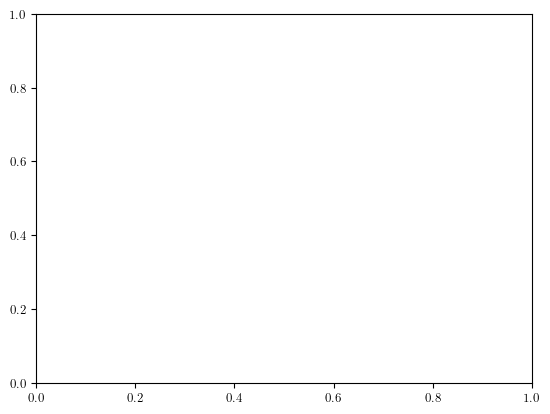

In [10]:
# Generate the density projections, this takes a few minutes per snapshot.

fig, ax = plt.subplots()
projections = []
hDims = []
midpoints = []
box_sizes = []

snaps_to_plot = [74, 79, 83] # change this as required

for snap_no in snaps_to_plot:
    bh_data = snapshot.loadSubset(basePath=basepath, snapNum = snap_no, partType=5, fields=['Coordinates', 'ParticleIDs'])
    bh_coordinates = bh_data['Coordinates']
    bh_ids = bh_data['ParticleIDs']
    if snap_no in bh_coords_1.keys() and snap_no in bh_coords_2.keys():
        bh_pos_1 = bh_coords_1[snap_no]
        bh_pos_2 = bh_coords_2[snap_no]
    else:
        bh_pos_1 = None
        bh_pos_2 = None
    if snap_no in pos_dict_combined1.keys():
        pos_1 = pos_dict_combined1[snap_no]
        vmax_1 = vmax_dict_combined1[snap_no]
    else:
        pos_1 = None
        vmax_1 = None
    if snap_no in pos_dict_combined2.keys():
        pos_2 = pos_dict_combined2[snap_no]
        vmax_2 = vmax_dict_combined2[snap_no]
    else:
        pos_2 = None
        vmax_2 = None
        
    projectRho, hDim, midpoint, box_size = get_density_projection(snap_no, pos_1, pos_2, vmax_1, vmax_2)
    projections.append(projectRho)
    hDims.append(hDim)
    midpoints.append(midpoint)
    box_sizes.append(box_size)

In [11]:
# Calculate the cosmological time
H0 = LITTLE_H * 100
Om0 = 0.3065
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
ages = []
scale_factors = fable_util.get_scale_factors()
for snap_no in snaps_to_plot:
    scale_factor = scale_factors[snap_no]
    redshift = 1/scale_factor - 1
    age = cosmo.age(redshift)
    ages.append(age)

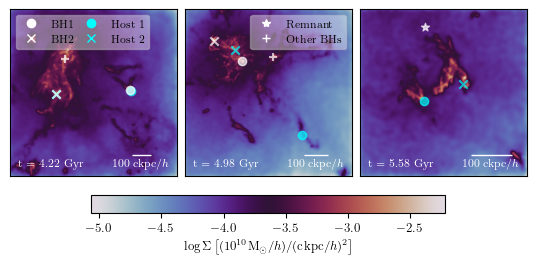

In [16]:
# Plot the density projections, edit as needed
fig, axes = plt.subplots(1, 3, figsize=(20/3, 5))
axes = axes.flatten()

im_list = []

fig.subplots_adjust(wspace=0.05, hspace=0.05)

for i, snap_no in enumerate(snaps_to_plot):
    bh_data = snapshot.loadSubset(basePath=basepath, snapNum=snap_no, partType=5, fields=['Coordinates', 'ParticleIDs'])
    bh_coordinates = bh_data['Coordinates']
    bh_ids = bh_data['ParticleIDs']
    if snap_no in bh_coords_1.keys() and snap_no in bh_coords_2.keys():
        bh_pos_1 = bh_coords_1[snap_no]
        bh_pos_2 = bh_coords_2[snap_no]
    else:
        bh_pos_1 = None
        bh_pos_2 = None
    if snap_no in pos_dict_combined1.keys():
        pos_1 = pos_dict_combined1[snap_no]
        vmax_1 = vmax_dict_combined1[snap_no]
    else:
        pos_1 = None
        vmax_1 = None
    if snap_no in pos_dict_combined2.keys():
        pos_2 = pos_dict_combined2[snap_no]
        vmax_2 = vmax_dict_combined2[snap_no]
    else:
        pos_2 = None
        vmax_2 = None

    projectRho = projections[i]
    hDim = hDims[i]
    midpoint = midpoints[i]
    box_size = box_sizes[i]

    ax = axes[i]

    ax.text(
        0.05, 0.04,  # (x, y) in normalized axis coordinates
        f"t = {ages[i]:.2f}",  
        color="white",
        verticalalignment="bottom",  
        horizontalalignment="left",
        transform=ax.transAxes,  # Use axis-relative coordinates
        fontsize=8
    )

    im = ax.imshow(np.log10(projectRho), origin='lower', extent=[-hDim, hDim, -hDim, hDim], cmap='twilight', interpolation='gaussian')
    im_list.append(im)

    scalebar = AnchoredSizeBar(ax.transData,
                        100,  # Length of the scale bar in data units
                        r'100 ckpc/$h$',  # Label for the scale bar
                        'lower right',  # Position: 'upper right', 'lower left', etc.
                        pad=0.5,
                        color='white',
                        frameon=False,
                        size_vertical=0.5,  # Thickness of the scale bar
                        fontproperties=fm.FontProperties(size=8))  # Adjust font size
    ax.add_artist(scalebar)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)  # Set tick length to 0
    ax.set_xlabel('')
    ax.set_ylabel('')
        
    subhalo_pos_1 = pos_1 - midpoint
    subhalo_pos_2 = pos_2 - midpoint

    ax.scatter(subhalo_pos_1[0], subhalo_pos_1[1], c='cyan', marker='o', label='Subhalo 1', alpha=0.7)
    ax.scatter(subhalo_pos_2[0], subhalo_pos_2[1], c='cyan', marker='x', label='Subhalo 2', alpha=0.7)

    vmin = -8
    vmax = -2

    ax.xaxis.set_major_locator(MaxNLocator(nbins=3))

    if bh_pos_1 is not None and bh_pos_2 is not None:
        aligned_coords_1 = bh_pos_1 - midpoint
        aligned_coords_2 = bh_pos_2 - midpoint

        ax.scatter(aligned_coords_1[0], aligned_coords_1[1], c='white', marker='o', label='BH1', alpha=0.7)
        ax.scatter(aligned_coords_2[0], aligned_coords_2[1], c='white', marker='x', label='BH2', alpha=0.7)

    else:
        # look for the remnant
        if id1 in bh_ids:
            index = np.where(bh_ids == id1)[0][0]
        elif id2 in bh_ids:
            index = np.where(bh_ids == id2)[0][0]
        else:
            index = None
        if index is not None:
            remnant_pos = bh_coordinates[index]
            aligned_coords = remnant_pos - midpoint
            ax.scatter(aligned_coords[0], aligned_coords[1], c='white', marker='*', label='Remnant', alpha=0.7)

    number_of_other_bhs = 0
    for j, bh_coords in enumerate(bh_coordinates):
        aligned_coords = bh_coords - midpoint
        BH_id = bh_ids[j]
        # check which BHs are within the box
        if np.linalg.norm(aligned_coords) < box_size and BH_id != id1 and BH_id != id2:
            number_of_other_bhs += 1
            if number_of_other_bhs == 1:
                ax.scatter(aligned_coords[0], aligned_coords[1], c='white', marker='+', label='Other BHs', alpha=0.7)
            else:
                ax.scatter(aligned_coords[0], aligned_coords[1], c='white', marker='+', alpha=0.7)


# Add a common colorbar
cbar = fig.colorbar(im_list[-1], ax=axes, orientation='horizontal', fraction=0.046, pad=0.05)
cbar.set_label(r'$\log \Sigma \left[(10^{10} \text{M}_\odot/h)/(\text{ckpc}/h)^2\right]$')

legend_elements = [
    Line2D([0], [0], marker='o', color='white', label='BH1', linestyle='None'),
    Line2D([0], [0], marker='x', color='white', label='BH2', linestyle='None'),
    Line2D([0], [0], marker='o', color='cyan', label='Host 1', linestyle='None'),
    Line2D([0], [0], marker='x', color='cyan', label='Host 2', linestyle='None'),
]

legend_elements2 = [
    Line2D([0], [0], marker='*', color='white', label='Remnant', linestyle='None'),
    Line2D([0], [0], marker='+', color='white', label='Other BHs', linestyle='None'),
]

cmap = plt.get_cmap('twilight')
# Add legend only to the top-left plot
legend = axes[0].legend(handles=legend_elements, loc='upper left', fontsize=8, ncol=2,columnspacing=0.5)
legend2 = axes[1].legend(handles=legend_elements2, loc='upper right', fontsize=8, ncol=1)
legend.get_frame().set_alpha(0.4)
legend2.get_frame().set_alpha(0.4)

# Hide the last subplot (bottom-right) if not used
if len(snaps_to_plot) < len(axes):
    axes[-1].axis('off')

plt.savefig(f'../figures/density_grid_2.png', dpi=600, bbox_inches = 'tight')
plt.show()